# WORKFLOW FOR CLOSED LOOP DESIGN

This notebook illustrates the structure of your final project.

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install tellurium
    !pip -q install control

In [44]:
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from typing import List, Optional

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

In [4]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 ->; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model.

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       NamedArray
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is None:
        data = rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        data = rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return data

# TESTS
data = plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
assert(len(data) > 0)
print("OK!")

OK!


In [6]:
def buildPITestbed(model, input_name, output_name, sign=1):
    """
    Creates an Antimony model of a PI controller using model as the open loop system.
    The resulting model as Antimony parameters for the setpoint, kP, kI. Assumes that
    this is a modular model (has an "end" statement).

    Args:
        model: str (Antimony model of OLS)
        input_name: str (name of a species in the OLS)
        output_name: str (name of a species in the OLS)
        sign: int (directional effect of input on output)

    Returns:
        str (Antimony model)
    """
    # Control codes
    control_logic = """
        // Parameters in CLS
        setpoint = 1
        kP = 1
        kI = 0
        sign = {sign}

        // Controller
        control_error := sign*(setpoint - {output_name})
        integral_control_error = 0
        integral_control_error' = control_error
        ${input_name} := kP*control_error + kI*integral_control_error
        """
    # Partition the model
    try:
        end_pos = model.index("end")
    except:
        end_pos = len(model) - 1
    model_front = model[:end_pos]
    model_back = model[end_pos:]
    return model_front + control_logic.format(input_name=input_name, output_name=output_name, sign=sign) + model_back

# TESTS
is_plot = False
cl_model = buildPITestbed(TEST_MODEL, "S1", "S3")
rr = te.loada(cl_model)
rr["kP"] = 10
rr["kI"] = 5
rr["setpoint"] = 8
rr.simulate(0, 10, 100, selections=["time", "setpoint", "S3"])
if is_plot:
    rr.plot()
print("OK!")

OK!


# Helpers

## plotStep

In [45]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [46]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [47]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [48]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# 1. Problem statement

The biological problem we address is controlling the concentration of pyruvate, ``s5`` in the Wolf model of glycolytic oscillations.  Our control objectives are:
* Regulate ``pyruvate` to a setpoint
* Fast settling times
* Avoid oscillations

# 2. System definition

The system we analyze has the following characteristics:
1. SBML model: BIOMDELS 206
1. output: na (NADP)
1. input: s5 (pyruvate)
1. directional effect of the input on the output: increasing (See below.)
1. operating region for the input: [0.5, 1] (See below.)
1. range of outputs that can be achieved: [8, 11]  (See below.)

In [8]:
# Global variables
INPUT_NAME = "na"
OUTPUT_NAME = "s5"
CTLSB = ControlSBML(WOLF_URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, times=TIMES)

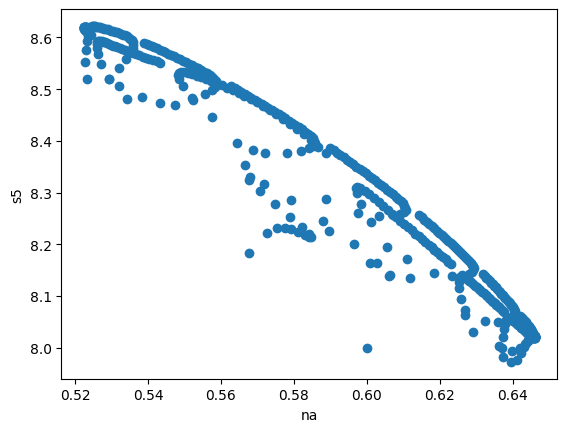

In [14]:
# Plot the relationship between the input and output at the same times
result = CTLSB.plotModel(is_plot=False)
df = result.timeseries[[INPUT_NAME, OUTPUT_NAME]]
inputs = df[INPUT_NAME]
outputs = df[OUTPUT_NAME]
plt.scatter(inputs, outputs)
plt.xlabel(INPUT_NAME)
plt.ylabel(OUTPUT_NAME)
if False:
    seconds = np.array(df.index)/1e3
    plt.plot(seconds, df[INPUT_NAME])
    plt.plot(seconds, df[OUTPUT_NAME])
    plt.xlabel("time")

The input and output seem to be related within the simulation. We can learn more by controlling the input to see the effect on the output.

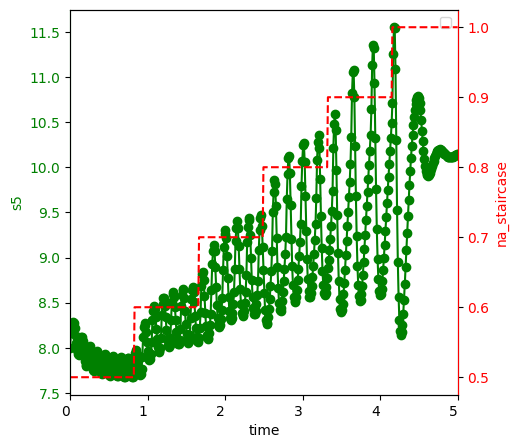

In [15]:
_ = CTLSB.plotStaircaseResponse(initial_value=0.5, final_value=1)

Clearly, the effect of the input ``na`` causes the output ``s5`` to increase. However, there is an initial transient, sustained oscillations, and a value of ``na`` that is larger than 1.0 has not effect. The output range is [8, 11.5].

The initial transient is likely related to initial conditions set by the model. We can ignore this since they disappear after a few hundred seconds.

# 3. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``na`` and the output is ``s5``. The input is varied over the operating region of [0.5, 1]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit.

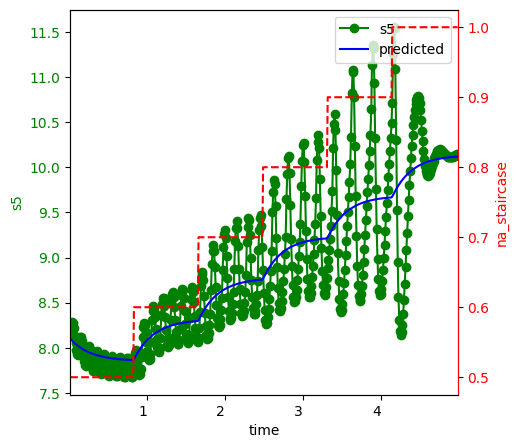

In [16]:
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, initial_value=0.5, final_value=1.0)

In [17]:
TRANSFER_FUNCTION = (10*s + 1.08)/(0.61*s + 0.19)
TRANSFER_FUNCTION

TransferFunction(array([10.  ,  1.08]), array([0.61, 0.19]))

In [18]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-0.31147541+0.j]), array([-0.108+0.j]))

# 4. Control design


## Testbed construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. We use a PI controller. We examine both the output response and the value of the input. The latter is to ensure that we are within the operating region.

In [19]:
antimony = CTLSB.getAntimony()
WOLF_CL = buildPITestbed(antimony, INPUT_NAME, OUTPUT_NAME, sign=1)

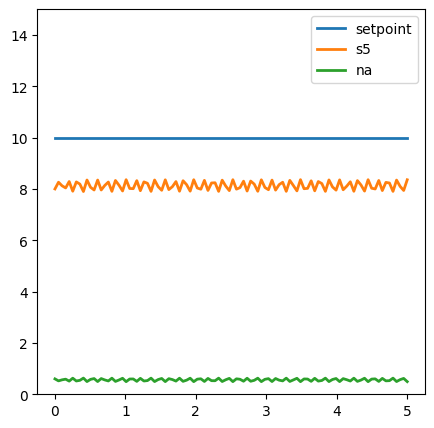

In [51]:
_ = plotModel(WOLF_CL, title="", selections=["setpoint", "s5", "na"],
              setpoint=10, kP=0.3, kI=0, ylim=[0, 15], times=np.linspace(0, 5, 100))

We are able to simulate the closed loop system, but it's not easy to find design parameters that meet our control objectives.

## Root locus analysis

P Controller

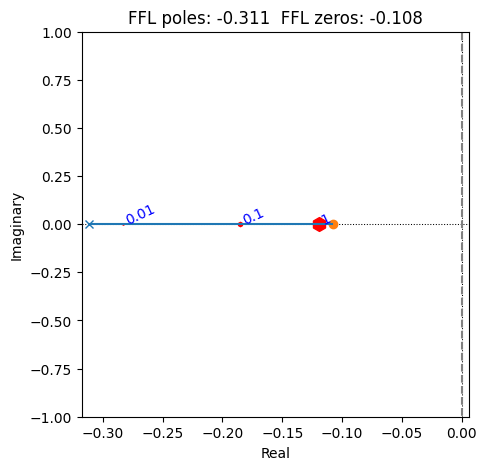

In [50]:
_ = plotRootLocusWithGains(TRANSFER_FUNCTION, [0.01, 0.1, 1])

This plot tells us that P-control will generally result in a slow system. It doesn't explain the oscillations in the simulation since the fitted transfer function does not have oscillations.

I Controller

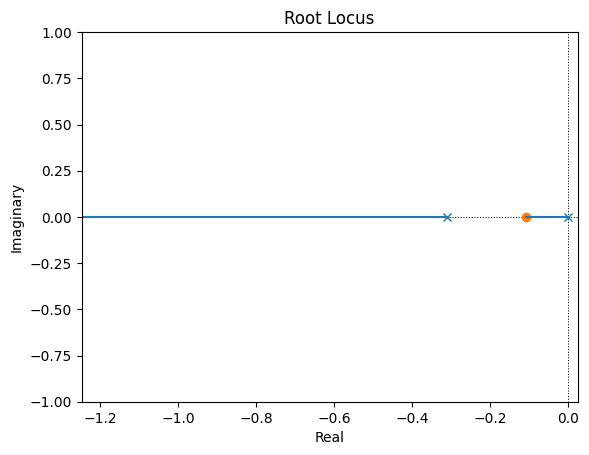

In [22]:
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

This plot suggests that I control can make the system faster because we move the dominant pole from 0 to -0.2.

## Grid Search

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.908492 and h = 1.83843e-118, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.850366 and h = 4.67285e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
  1%|▏         | 1/80 [00:01<01:36,  1.22s/it]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.73385 and h = 3.89813e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 9.99274e-05 and h = 9.63058e-118, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.740349 and h = 1.55722e-117, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_C

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr

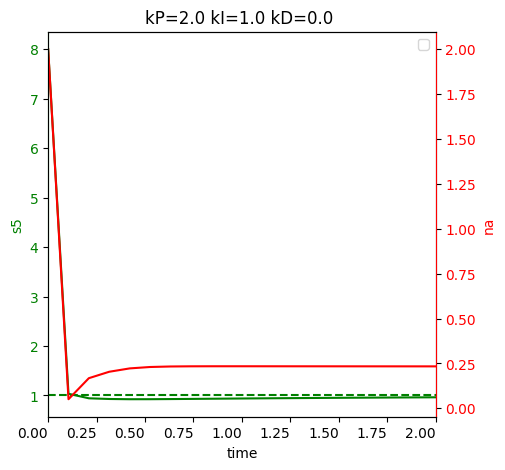

In [37]:
# Grid Search Using plotGrid
setpoint = 5
grid = Grid()
grid.addAxis("kP", num_coordinate=5, min_value=0.1, max_value=2)
grid.addAxis("kI", num_coordinate=5, min_value=0.1, max_value=1)
grid.addAxis("kD", num_coordinate=3, min_value=0, max_value=1)
result = CTLSB.plotGridDesign(grid, times=np.linspace(0, 2, 20))

In [42]:
result.design_df[result.design_df['score'].notna()]

,kI,reason,kP,kD,score
0,1.000,Design successful.,2.000,0.0,2.453078e+00
1,0.775,Design successful.,2.000,0.0,2.454079e+00
2,1.000,Design successful.,1.525,0.0,2.454901e+00
3,0.550,Design successful.,2.000,0.0,2.455462e+00
4,0.775,Design successful.,1.525,0.0,2.456529e+00
5,0.325,Design successful.,2.000,0.0,2.457386e+00
6,1.000,Design successful.,1.050,0.0,2.458373e+00
7,0.550,Design successful.,1.525,0.0,2.458847e+00
8,0.100,Design successful.,2.000,0.0,2.460084e+00
9,0.775,Design successful.,1.050,0.0,2.461323e+00


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.256532 and h = 2.64073e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.042388 and h = 3.38357e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.031185 and h = 1.55762e-15, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0248426 and h = 9.85837e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0203717 and h = 2.20782e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Mes

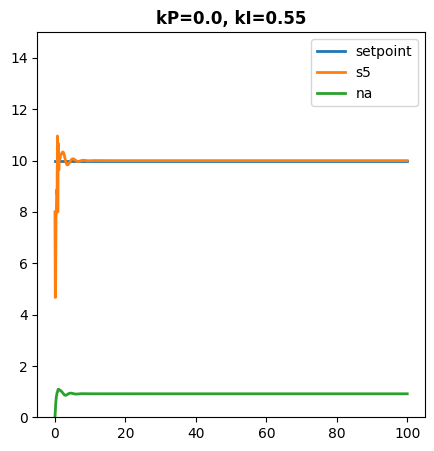

In [23]:
# Set the search parameters and initialize
setpoint = 10
best_rmse = 1e6
best_ks = []
kPs = [0.05*n for n in range(20)]
kIs = [0.05*n for n in range(20)]
# Do the grid search
for kI in kIs:
    for kP in kPs:
        try:
            data = plotModel(WOLF_CL, title="", selections=["setpoint", "s5", "na"], is_plot=False,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0, 15], times=np.linspace(0, 100, 1000))
        except:
            continue
        outputs = data[OUTPUT_NAME]
        rmse = np.sum((setpoint - outputs)**2)
        if rmse < best_rmse:
            best_mse = rmse
            best_ks = [kP, kI]
# Report the results
if len(best_ks) == 0:
    print("\n***No design found.")
else:
    kP = best_ks[0]
    kI = best_ks[1]
    title = "kP={kP}, kI={kI}".format(kP=kP, kI=kI)
    _ = plotModel(WOLF_CL, selections=["setpoint", "s5", "na"], is_plot=True,
                      setpoint=setpoint, kP=kP, kI=kI, ylim=[0, 15], 
                  times=np.linspace(0, 100, 1000), title=title)

# 5. Discussion

This section discusses issues encountered in the design.